# Budowa modelu sieci konwolucyjnych do rozpoznawania obrazów ze zbioru CIFAR100



### Opis zbioru danych:



CIFAR100 (Canadian Institute For Advanced Research) jest popularnym zbiorem benchmarkowym, wykorzystywanym do nauki i oceny algorytmów uczenia maszynowego oraz rozpoznawania obrazów. Jest to bardziej rozbudowana wersja zbioru CIFAR10, posiada 100 klas obrazów, czyli 10 razy więcej niż poprzednik. Każda z klas zawiera 600 kolorowych obrazów o wymiarze 32x32 pikseli, łacznie znajdziemy ich 60000 w całym zestawie.



#### CIFAR100 został pogrupowany na odpowiednie superklasy oraz klasy:



|Superclasses | Classes|
|- |- |
|aquatic mammals| beaver, dolphin, otter, seal, whale|
|fish| aquarium fish, flatfish, ray, shark, trout|
|flowers| orchids, poppies, roses, sunflowers, tulips|
|food containers| bottles, bowls, cans, cups, plates|
|fruit and vegetables| apples, mushrooms, oranges, pears, sweet peppers|
|household electrical devices| clock, computer keyboard, lamp, telephone, television|
|household furniture| bed, chair, couch, table, wardrobe|
|insects| bee, beetle, butterfly, caterpillar, cockroach|
|large carnivores| bear, leopard, lion, tiger, wolf|
|large man-made outdoor things| bridge, castle, house, road, skyscraper|
|large natural outdoor scenes| cloud, forest, mountain, plain, sea|
|large omnivores and herbivores| camel, cattle, chimpanzee, elephant, kangaroo|
|medium-sized mammals| fox, porcupine, possum, raccoon, skunk|
|non-insect invertebrates| crab, lobster, snail, spider, worm|
|people| baby, boy, girl, man, woman|
|reptiles| crocodile, dinosaur, lizard, snake, turtle|
|small mammals| hamster, mouse, rabbit, shrew, squirrel|
|trees| maple, oak, palm, pine, willow|
|vehicles 1| bicycle, bus, motorcycle, pickup truck, train|
|vehicles 2| lawn-mower, rocket, streetcar, tank, tractor|



"Yes, I know mushrooms aren't really fruit or vegetables and bears aren't really carnivores."

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
import math

#### Załadowanie zbioru danych

In [ ]:
#dataset loading
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

169009152/169001437 [==============================] - 2s 0us/step


#### Po załadowaniu danych pierwszą czynnością było sprawdzenie wymiarowości danych – liczby pikseli na zdjęciach i kanałów RGB i zapisanie jako wymiary wejściowe

In [ ]:
#data shape
input_shape = x_train.shape[1:]

### Następnie ustawione zostało kilka parametrów
- Sprawdzona została liczba klas, aby upewnić się czy model został prawidłowo wgrany.
- Ustawione zostało ziarno losowe na poziomie 1234, aby otrzymywać powtarzalność wyników
- Przyjętę zostało 100 epok z użyciem Early Stopping sprawdzającym co 10 epok (wytłumaczone w dalszej części raportu)
- Batch size na poziomie 128

In [ ]:
# number of classes
classes = len(np.unique(y_train))
random_state = 1234
epochs = 100
Batch_size = 128

#### W tej części dokonana została standaryzacja danych celem zmniejszenia odległości pomiędzy tensorami w sieci, co w większości przypadków jest zalecane i powoduje zwiększenie wyników.

In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0

#### Tu dokonana została zmiana struktury macierzy danych wynikowych. W pierwotnej wersji sieć nie mogła zweryfikować swojej istotności, ponieważ dane wynikowe zawierały tylko jedną kolumnę z wynikiem od 0 do 100, w czasie gdy sieć zwracała wyniki w formie macierzy zawierającej 100 kolumn. Poniższy kod zmieniał wymiarowość macierzy, doprowadzając je do tego samego formatu.

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=100)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=100)

### Data augmentation Po polsku rozszerzanie danych - to technika służąca do zwiększania ilości danych poprzez dodawanie nieznacznie zmodyfikowanych kopii już istniejących danych lub nowo utworzonych danych syntetycznych z istniejących danych. Działa jak regularyzator i pomaga zmniejszyć nadmierne dopasowanie podczas szkolenia modelu.

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

## Model sieci konwolucyjnej
><b>Do rozwiązania problemu posłużono się siecią konwolucyjnymi</b>, ponieważ ze względu na ich umiejętność stopniowego filtrowania różnych części danych uczących oraz wyostrzania ważnych cech świetnie sprawdzają się one w procesie rozpoznawania obrazów.

### Opis architektury sieci konwolucyjnych
> <b>Deep learning pozwala modelom obliczeniowym wielu warstw przetwarzania, nauczyć się i reprezentować dane z wieloma poziomami abstrakcji</b> naśladując, w jaki sposób mózg odbiera i rozumie informacje multimodalne, a więc przechwytuje skomplikowane struktury danych na dużą skalę. Konwolucyjne sieci neuronowe są oparte na algorytmie głębokiego uczenia. Wykorzystuje się je w celu przetwarzania danych, które składają się z wielowymiarowych macierzy. Przykładem takich macierzy są obrazy, dlatego sieci te sprawdzają się dobrze w przetwarzania obrazów.
<br><br> <b>Architektura sieci konwolucyjnych</b> wykorzystuje trzy konkretne pomysły:  lokalne pola receptywne,  powiązane obciążeń i podpróbkowanie przestrzenne. W oparciu o lokalne pole receptywne, każda jednostka w warstwie splotowej otrzymuje dane wejściowe z zestawu sąsiednich jednostek należących do poprzedniej warstwy. W ten sposób neurony są w stanie wyodrębnić elementarne części wizualne, takie jak krawędzie lub rogi. Funkcje te są następnie łączone przez kolejne warstwy splotowe w celu wykrycia cech wyższego rzędu. Ponadto idea, że elementarne detektory cech, które są użyteczne na części obrazu, mogą być użyteczne w całym obrazie, jest realizowana przez koncepcję wiązania obciążeń. Pojęcie wiązanych obciążeń ogranicza zestaw jednostek, aby miały identyczne wagi.
<br><br> Podstawą konstrukcji sieci konwolucyjnej są <b>warstwy</b> przyjęte w ilości i rozmiarze, który zależy od stopnia złożoności zadania rozpoznawania. Z uwagi na charakter danych wejściowych (dane obrazowe) oraz stosowane współcześnie metody uczenia, powszechne jest stosowanie warstw. <b>Warstwa wejściowa</b> jest zdefiniowana rozmiarami obrazów poddawanych przetwarzaniu i otrzymuje surowe wartości ich pikseli, które w procesie uczenia są eksponowane wraz z informacją o przynależności do klas. Wymiar warstwy to wysokość i szerokość obrazów wejściowych, które w ramach wstępnego przetwarzania muszą być ujednolicone. <b>Warstwę konwolucyjną</b> tworzy pewna liczba zbiorów neuronów. Wejścia każdego z neuronów połączone są z pewną liczbą pikseli obrazu wejściowego tworzących lokalne, prostokątne pola recepcyjne o zadanych wymiarach lub z pewną liczbą elementów warstwy poprzedzającej, jeśli sieć posiada kilka warstw konwolucyjnych. Dla każdego ze zbiorów neuronów na etapie uczenia wyznaczane są <b>wagi</b>, przy czym każdy z neuronów należących do określonego zbioru ma te wagi jednakowe. Przetwarzanie obrazu przez nauczoną warstwę konwolucyjną może być więc ekwiwalentnie zastąpione jego filtracją zrealizowaną za pomocą splotu (konwolucji) z wykorzystaniem neuronów-filtrów o ustalonych wagach-współczynnikach. Zbiór wszystkich powstałych w wyniku splatania obrazów tworzy mapy cech.
<br><br>Operację łączenia wielu wyników pochodzących z sąsiedztwa w mapach cech w jedną cechę realizuje warstwa redukująca tzw. <b>warstwa poolingu</b>. Warstwa ta realizuje filtrację statystyczną w obrębie maski o zadanych rozmiarach wyznaczając wybraną statystykę, np. wartość maksymalną, minimalną lub średnią. Maski przetwarzające obraz w ten sposób nie pokrywają się. W warstwie tej nie występuje proces uczenia, ale dzięki możliwości wybrania odpowiednio dużego kroku przy przesuwaniu maski otrzymuje się redukcję wymiarów map cech (pomniejszone mapy cech), co sprzyja poprawie szybkości uczenia. Poza tym, w przypadku stosowania po niej kolejnej warstwy konwolucyjnej, warstwa redukująca daje jej neuronom możliwość objęcia większej powierzchni obrazu i tym samym kształtowanie innych rodzajów cech. Sieć uzyskuje również pewną odporność na przesunięcia wzorców obrazów. Warstwa ta tym samym ogranicza również ryzyko przetrenowania.
<br><br> <b>Do budowy sieci wybrano warstwę poolingu typu max, która jest najpopularniejszym rodzajem warstwy łączącej. Dalsze decyzje doboru hiperparametrów przedstawiono w dalszej części pracy. </b>

### Funkcje aktywacji
>Rolą funkcji aktywacji jest przedstawienie, w jakim stopniu dany neuron jest pobudzony aktualnie docierającymi do niego wartościami.
Wynik działania warstwy konwolucyjnej może zawierać wartości ujemne, które są eliminowane przez nieliniową <b>funkcję aktywacji o nazwie ReLU (ang. rectified linear unit)</b>. Funkcja ta wartości pikseli, które w mapach cech są dodatnie pozostawia bez zmian a ujemne zamienia na zerowe. Funkcja ReLU jest nieco szybsza od pozostałych funkcji aktywacji, a ponadto algorytm spadku gradientowego rzadziej zatrzymuje się na wypłaszczeniach ze względu na większą odporność na duże wartości wejściowe. Funkcja logistyczna i tangensa hiperbolicznego sprawdzają się nieco gorzej, gdyż ulegają nasyceniu w punkcie 1, por. Geron (2017). <b> Ze względu na powyższe w pracy posłużono się funkcją ReLU. </b><br><br>
<b>W przypadku warstwy wyjściowej pojedynczą funkcję aktywacji zastąpiono współdzieloną funkcją typu softmax</b>, która dla każdej obserwacji oblicza prawdopodobieństwo przynależności obrazu wejściowego do określonej kategorii. Funkcja ta jest odpowiednia do przedstawionego problemu ze względu na wzajemnie wykluczające się klasy zdjęć.

### Algorytm optymalizacji

> Algorytmy optymalizacji pomagają zminimalizować (lub zmaksymalizować) funkcję straty, która jest zależna od wewnętrznych parametrów uczenia się modelu oraz która jest używana do obliczania wartości docelowych na podstawie zestawu predyktorów. W praktyce oznacza to, że wagi i odchylenia są wykorzystywane do obliczenia wartości wyjściowych i aktualizowane tak, aby dążyć w kierunku optymalnego rozwiązania.
Jednym z przykładowych algorytmów optymalizujących jest ADAM
- <B>ADAM</B> (Adaptive Moment Estimation) - działa dobrze w praktyce i wypada korzystnie w porównaniu z innymi algorytmami adaptacyjnej metody uczenia się, ponieważ zbiega bardzo szybko, a szybkość uczenia się modelu przebiega równie sprawnie i efektywnie.  Dodatkowo naprawia problemy spotykane w innych technikach optymalizacji takie jak: zanikająca stopa uczenia, powolne osiąganie kryterium zbiezności lub wysoka wariancja w aktualizowaniu parametrów co prowadzi do wahań w funkcji straty.*

### Przeuczenie i regularyzacja
Elastyczność związana z ogromną liczbą parametrów sieci neuronowych związana jest z podatnością na ich <b>przetrenowanie</b>. Wśród technik regularyzacji wyróżnić można: wczesne <b>zatrzymywanie, modyfikacje funkcji kosztu, porzucanie (dropout), regularyzacja typu max-norm oraz dogenerowanie danych z istniejących przykładów</b>.  
<br><b>W pracy do budowy modeli sieci konwolucyjnej posłużono się metodą wczesnego zatrzymywania</b> polegającą na przerwaniu procesu uczenia sieci w momencie spadku wydajnośći modelu wobec zbioru walidacyjnego. Zaimplementowano tę metodę poprzez ocenianie wydajności modelu w regularnych odstępach czasu i ocenę wielkości błędu na poszczególnych zbiorach na wykresie.
W miarę upływu kolejnych epok procesu uczenia algorytm uczy się, a więc błąd predycji spada, a rośnie dokładność na zestawie uczącym. Jeśli jednak błąd na danych walidacyjnych zaczyna rosnąć, oznacza to, że model ulega przetrenowaniu. Wczesne zatrzymanie umożliwia przerwanie procesu w momencie osiągnięcia minimalnej wartości błędu predykcji.
<b>Posłużono się również techniką regularyzacji dropout </b>
Jest to najpopularniejsza z technik regularyzacji zaproponowana przez G. E. Hintona w 2012 roku. Istnieje wiele prac dowodzących skuteczności tej metody - nawet najbardziej złożone sieci neuronowe uzyskują 1-2% poprawę precyzji przez zastosowanie dropoutu. Idea algorytmu opiera się na prostym założeniu: w procesie uczenia z każdym krokiem każdy neuron z wyjątkiem tych z warstwy wyjściowej posiada prawdopodobieństwo <i>p</i> bycia porzuconym ze zbioru w tym kroku. Hiperparametr <i>p</i> zazwyczaj przyjmuje poziom 50%.

### Budowa modelu
> <b> W procedurze budowy najlepszego modelu trenowano wiele różnych sieci. W pracy zaprezentowano jedynie model dwa modele sieci konwolucyjnej - o mniej oraz bardziej skomplikowanej architekturze. Model finalny okazał się być modelem najlepszym, a poprzedzający posłużył w pracy jako benchmark, został zoptymalizowany za pomocą funkcji dropout, dodaniem warstwy Maxpooling i funkcji BatchNormalization, model finalny osiągnął znacznie lepszy wynik na zbiorze testowy co świadczy o tym, że dodanie tych funcji pozwoliło na zmniejszenie przeuczenia modelu.

## Model building

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                  kernel_initializer='he_normal',
                 input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))

model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu'))

model.add(Conv2D(256, kernel_size=(3, 3),
                 activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3),
                 activation='relu'))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))

model.add(Dense(512, activation='relu'))

model.add(Dense(classes, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss= losses.CategoricalCrossentropy(from_logits=True), metrics='accuracy')

In [ ]:
train_model = model.fit(datagen.flow(x_train, y_train, batch_size=128),
                  epochs=epochs,
                  callbacks=[early_stopping],
                  verbose=1,
                  validation_data=(x_test, y_test))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
391/391 [==============================] - 39s 98ms/step - loss: 4.5505 - accuracy: 0.0343 - val_loss: 3.8593 - val_accuracy: 0.0998
Epoch 2/100
391/391 [==============================] - 39s 100ms/step - loss: 3.8149 - accuracy: 0.1075 - val_loss: 3.4844 - val_accuracy: 0.1624
Epoch 3/100
391/391 [==============================] - 40s 101ms/step - loss: 3.5660 - accuracy: 0.1495 - val_loss: 3.3259 - val_accuracy: 0.1983
Epoch 4/100
391/391 [==============================] - 39s 100ms/step - loss: 3.3775 - accuracy: 0.1847 - val_loss: 3.1761 - val_accuracy: 0.2201
Epoch 5/100
391/391 [==============================] - 39s 101ms/step - loss: 3.2336 - accuracy: 0.2097 - val_loss: 3.0283 - val_accuracy: 0.2467
Epoch 6/100
391/391 [==============================] - 39s 101ms/step - loss: 3.1256 - accuracy: 0.2268 - val_loss: 2.9542 - val_accuracy: 0.2663
Epoch 7/100
391/391 [==============================] - 39s 101ms/step - loss: 3.0213 - accuracy: 0.2480 - val_loss: 2.8580 - 

In [ ]:
score = model.evaluate(x_test, y_test, steps=math.ceil(10000/32))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 3s 8ms/step - loss: 2.0936 - accuracy: 0.4537
Test loss: 2.093562126159668
Test accuracy: 0.4537000060081482


Po pierwszym treningu modelu widać, że jest on trochę przeuczony i można go jeszcze usprawnić

###Tuning modelu

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                  kernel_initializer='he_normal',
                 input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3, 3),
                 activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(classes, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss= losses.CategoricalCrossentropy(from_logits=True), metrics='accuracy')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
391/391 [==============================] - 30s 74ms/step - loss: 4.6550 - accuracy: 0.0353 - val_loss: 4.3104 - val_accuracy: 0.0556
Epoch 2/100
391/391 [==============================] - 28s 71ms/step - loss: 4.0315 - accuracy: 0.0772 - val_loss: 3.9333 - val_accuracy: 0.0940
Epoch 3/100
391/391 [==============================] - 28s 71ms/step - loss: 3.8582 - accuracy: 0.1020 - val_loss: 3.9326 - val_accuracy: 0.1065
Epoch 4/100
391/391 [==============================] - 28s 71ms/step - loss: 3.6796 - accuracy: 0.1286 - val_loss: 3.4137 - val_accuracy: 0.1767
Epoch 5/100
391/391 [==============================] - 28s 72ms/step - loss: 3.5660 - accuracy: 0.1522 - val_loss: 3.1739 - val_accuracy: 0.2098
Epoch 6/100
391/391 [==============================] - 28s 72ms/step - loss: 3.4511 - accuracy: 0.1665 - val_loss: 3.0001 - val_accuracy: 0.2526
Epoch 7/100
391/391 [==============================] - 28s 72ms/step - loss: 3.3552 - accuracy: 0.1857 - val_loss: 3.0664 - val_ac

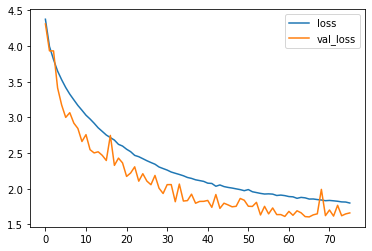

In [ ]:
train_model = model.fit(datagen.flow(x_train, y_train, batch_size=128),
                  epochs=epochs,
                  callbacks=[early_stopping],
                  verbose=1,
                  validation_data=(x_test, y_test))

history_df = pd.DataFrame(train_model.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [ ]:
score = model.evaluate(x_test, y_test, steps=math.ceil(10000/32))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 5ms/step - loss: 1.6049 - accuracy: 0.5645
Test loss: 1.604914903640747
Test accuracy: 0.5644999742507935


## Cifar10
> W celu pokazania jakości modelu, model o tej samej architekrurze co model finalny został nauczony i przetestowany na znacznie prostszym ale podobnym datasecie Cifar10

In [ ]:
#dataset loading CIFAR10
(x10_train, y10_train), (x10_test, y10_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
#data shape 10
input_shape10 = x10_train.shape[1:]

In [ ]:
x10_train = x10_train / 255.0
x10_test = x10_test / 255.0

>Tutaj inaczej niż jak przy CIFAR-100, wymiarowość zmieniona została do postacji 10 kolumn, aby dopasować się do 10 klas w tym zbiorze danych

In [ ]:
y10_train = tf.keras.utils.to_categorical(y10_train, num_classes=10)
y10_test = tf.keras.utils.to_categorical(y10_test, num_classes=10)

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

#### Model Finalny

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model10 = Sequential()
model10.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                  kernel_initializer='he_normal',
                 input_shape=input_shape10))
model10.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
model10.add(tf.keras.layers.BatchNormalization())
model10.add(Dropout(0.3))

model10.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu'))
model10.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu'))
model10.add(MaxPooling2D(pool_size=(2, 2)))
model10.add(tf.keras.layers.BatchNormalization())
model10.add(Dropout(0.4))

model10.add(Conv2D(256, kernel_size=(3, 3),
                 activation='relu'))
model10.add(Conv2D(256, kernel_size=(3, 3),
                 activation='relu'))
model10.add(MaxPooling2D(pool_size=(2, 2)))
model10.add(tf.keras.layers.BatchNormalization())
model10.add(Dropout(0.5))

model10.add(Flatten())
model10.add(Dense(1024, activation='relu'))
model10.add(Dropout(0.4))
model10.add(Dense(512, activation='relu'))
model10.add(Dropout(0.3))
model10.add(Dense(10, activation='softmax'))

In [ ]:
model10.compile(optimizer='adam', loss= losses.CategoricalCrossentropy(from_logits=True), metrics='accuracy')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
391/391 [==============================] - 37s 74ms/step - loss: 2.1898 - accuracy: 0.2540 - val_loss: 1.7604 - val_accuracy: 0.3389
Epoch 2/100
391/391 [==============================] - 28s 72ms/step - loss: 1.6348 - accuracy: 0.3966 - val_loss: 1.4160 - val_accuracy: 0.4779
Epoch 3/100
391/391 [==============================] - 28s 71ms/step - loss: 1.4362 - accuracy: 0.4820 - val_loss: 1.7721 - val_accuracy: 0.4616
Epoch 4/100
391/391 [==============================] - 28s 72ms/step - loss: 1.3059 - accuracy: 0.5371 - val_loss: 1.1546 - val_accuracy: 0.6072
Epoch 5/100
391/391 [==============================] - 28s 71ms/step - loss: 1.2253 - accuracy: 0.5645 - val_loss: 0.9594 - val_accuracy: 0.6607
Epoch 6/100
391/391 [==============================] - 28s 71ms/step - loss: 1.1587 - accuracy: 0.5926 - val_loss: 1.3107 - val_accuracy: 0.5932
Epoch 7/100
391/391 [==============================] - 28s 71ms/step - loss: 1.1268 - accuracy: 0.6033 - val_loss: 0.9690 - val_ac

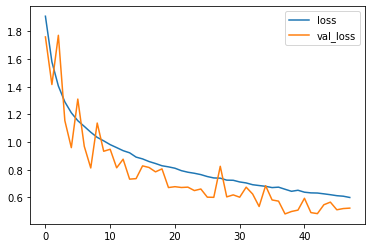

In [ ]:
train_model = model10.fit(datagen.flow(x10_train, y10_train, batch_size=128),
                  epochs=epochs,
                  callbacks=[early_stopping],
                  verbose=1,
                  validation_data=(x10_test, y10_test))

history_df = pd.DataFrame(train_model.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [ ]:
score = model10.evaluate(x10_test, y10_test, steps=math.ceil(10000/32))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 5ms/step - loss: 0.4800 - accuracy: 0.8347
Test loss: 0.4799579083919525
Test accuracy: 0.8346999883651733


## Wnioski
>Celem raportu było stworzenie modelu sieci neuronowych, który pozwoli precyzyjnie podporządkować obrazy ze zbioru CIFAR100 do odpowiadających im 100 klas. Ostateczny model powstał po wielu próbach i dzięki wyciągniętym wnioskom, odpowiednio dostosowano hiperparametry oraz wybrano funkcje aktywacji. Pierwszy zaprezentowany model pokazuje jaka poprawa nastąpiła po kalibracji modelu, wstępna trafność wynosi około 45%, co było wynikiem niezadowalającym. Po zastosowaniu funkcji: Dropuot, BatchNormalization i Maxpooling precyzja wzrosła do ponad 56%. Wydaje się to także wynikiem przeciętnym, warto jednak zwrócić uwagę, iż zbiór zawiera aż 100 klas obiektów. Aby pokazać różnicę w poziomie trudności wykorzystany model został dodatkowo wykorzystany do rozpoznania obrazów na zbiorze CIFAR10, tam jego precyzja wynosi ponad 83% co może świadczyć o dobrej jakości modelu.

## Bibliografia
1. Deep Learning - Ian Goodfellow, Aaron Courville
Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts,Tools, and Techniques to Build Intelligent Systems - Aurelien Geron Revisiting Small Batch Training for Deep Neural Networks, 2018 - Dominic Masters, Carlo Luschi.

2. Canadian Institute For Advanced Research "https://www.cs.toronto.edu/~kriz/cifar.html", dostęp 03.2023
